In [1]:
!pip install ydata_profiling
!pip install openpyxl
!pip install umap-learn
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for SMOTENC
from imblearn.over_sampling import SMOTENC
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.utils.class_weight import compute_class_weight


import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [3]:
df_train = pd.read_csv("arvato_data/data/Udacity_MAILOUT_052018_TRAIN.csv",sep=';', dtype='category')
df_test = pd.read_csv("arvato_data/data/Udacity_MAILOUT_052018_TEST.csv",sep=';', dtype='category')

we will combine them and them for easier processing, and seperate them later.  We just should be careful about the operations applied to the test dataset

In [4]:
df_train['type'] = 'train'
df_test['type'] = 'test'

In [5]:
all_data = pd.concat([df_train, df_test], axis=0)
all_data.reset_index(drop=True, inplace=True)

## Replace unknown values with NaN

In [6]:
attribute_desc_path = 'arvato_data/data/DIAS Attributes - Values 2017.xlsx'
attribute_desc_df = pd.read_excel(attribute_desc_path)
attribute_desc_df.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [7]:
def get_unknown_values(attribute_desc_df, meaning_keywords=['unknown']):
    """
    Extracts a dictionary mapping each attribute to its 'unknown' values based on meaning keywords.

    Parameters:
    - attribute_desc_df (pd.DataFrame): DataFrame containing attribute descriptions.
    - meaning_keywords (list of str): Keywords indicating an 'unknown' meaning.

    Returns:
    - dict: Dictionary with attribute names as keys and lists of 'unknown' values as values.
    """
    unknown_values_dict = {}
    
    # Ensure 'Meaning' column is string type for safe string operations
    attribute_desc_df['Meaning'] = attribute_desc_df['Meaning'].astype(str)
    
    # Iterate over each attribute
    for attr in attribute_desc_df['Attribute'].unique():
        attr_rows = attribute_desc_df[attribute_desc_df['Attribute'] == attr]
        
        # Identify rows where 'Meaning' contains any of the given keywords (case-insensitive)
        mask = attr_rows['Meaning'].str.contains('|'.join(meaning_keywords), case=False, na=False)
        unknown_rows = attr_rows[mask]
        
        if not unknown_rows.empty:
            # Collect all unknown values for this attribute
            all_unknown_values = []
            for val in unknown_rows['Value'].dropna().unique():
                # Split by comma in case multiple unknown values are listed
                split_vals = [v.strip() for v in str(val).split(',')]
                
                # Attempt to convert each split value to int or float
                processed_values = []
                for v in split_vals:
                    try:
                        # Try float first to handle cases like '0.0' if any
                        # if '.' in v:
                        processed_values.append(v)
                        # else:
                        #     processed_values.append(int(v))
                    except ValueError:
                        # If conversion fails, keep as string
                        processed_values.append(v)
                
                all_unknown_values.extend(processed_values)

            # Store the list of unknown values for this attribute
            unknown_values_dict[attr] = list(set(all_unknown_values))  # use set to remove duplicates if needed

    return unknown_values_dict

In [8]:
unknown_values_dict = get_unknown_values(attribute_desc_df)

In [9]:
print(all_data.isna().sum().sum())

4446769


In [10]:
for col, unknown_values in unknown_values_dict.items():
    if col in all_data.columns:
        all_data[col] = all_data[col].replace(unknown_values, np.nan)

/tmp/ipykernel_4347/3741086660.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  all_data[col] = all_data[col].replace(unknown_values, np.nan)


In [11]:
print(all_data.isna().sum().sum())

4719423


## Numeric datatype

In [12]:
def get_numeric_columns(attribute_desc_df, numeric_keywords=['numeric value']):
    """
    Extracts a list of attributes that are described as numeric based on keywords in their descriptions.

    Parameters:
    - attribute_desc_df (pd.DataFrame): DataFrame containing attribute descriptions.
    - numeric_keywords (list of str): Keywords indicating a numeric value.

    Returns:
    - list: List of attribute names marked as numeric.
    """
    numeric_columns = []
    attribute_desc_df['Description'] = attribute_desc_df['Description'].astype(str)
    
    for attr in attribute_desc_df['Attribute'].unique():
        attr_rows = attribute_desc_df[attribute_desc_df['Attribute'] == attr]
        mask = attr_rows['Meaning'].str.contains('|'.join(numeric_keywords), case=False, na=False)
        if mask.any():
            numeric_columns.append(attr)
    
    return numeric_columns


In [13]:
numeric_columns = get_numeric_columns(attribute_desc_df)
numeric_columns

['ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR']

In [14]:
def convert_to_numeric(df, numeric_columns):
    """
    Converts specified columns in a DataFrame to numeric, coercing errors to NaN.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to process.
    - numeric_columns (list): List of column names to convert to numeric.
    
    Returns:
    - pd.DataFrame: The updated DataFrame.
    """
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('float32')

        else:
            print(f"Column '{col}' not found in DataFrame.")
    return df
    

In [15]:
all_data = convert_to_numeric(all_data, numeric_columns)

all_data[numeric_columns].dtypes

ANZ_HAUSHALTE_AKTIV    float32
ANZ_HH_TITEL           float32
ANZ_PERSONEN           float32
ANZ_TITEL              float32
GEBURTSJAHR            float32
KBA13_ANZAHL_PKW       float32
MIN_GEBAEUDEJAHR       float32
dtype: object

## Binary datatype

In [16]:
binary_cols = []
for col in all_data.columns:
    n_unique = all_data[col].dropna().nunique()
    if n_unique == 2:
        binary_cols.append(col)
binary_cols  

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KBA05_SEG6',
 'KONSUMZELLE',
 'OST_WEST_KZ',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP',
 'RESPONSE',
 'ANREDE_KZ',
 'type']

Set these columns to category to prevent a numerical processing of these features

In [17]:
# They should already be category, but just a safety net
all_data[binary_cols] = all_data[binary_cols].astype('category')

# Remove/Transform Features

LNR is a unique identifier.  EINGEFUEGT_AM is a date item.  we could chunk it and classify it into chunks, but for this project we will simply drop it to save on time.

In [18]:
columns_to_drop = ['LNR']

## Binning birth year

In [19]:
all_data['GEBURTSJAHR'] = all_data['GEBURTSJAHR'].replace(0.0, np.nan)
all_data['GEBURTSJAHR']

0           NaN
1        1957.0
2        1929.0
3        1924.0
4        1936.0
          ...  
85790       NaN
85791    1943.0
85792    1966.0
85793       NaN
85794       NaN
Name: GEBURTSJAHR, Length: 85795, dtype: float32

In [20]:
all_data['GEBURTSJAHR'] = pd.to_numeric(all_data['GEBURTSJAHR'], errors='coerce')

In [21]:
# bins for 10-year intervals
bins = range(1900, 2021, 10)
labels = [f"{start}-{start+9}" for start in bins[:-1]]

all_data['GEBURTSJAHR_BINNED'] = pd.cut(
    all_data['GEBURTSJAHR'], 
    bins=bins, 
    labels=labels, 
    right=False  # Include the left bin edge, exclude the right
)

binned_counts = all_data['GEBURTSJAHR_BINNED'].value_counts().sort_index()
print(binned_counts)

GEBURTSJAHR_BINNED
1900-1909       10
1910-1919      185
1920-1929     3980
1930-1939    12323
1940-1949    12764
1950-1959    10286
1960-1969     6716
1970-1979     2682
1980-1989     1249
1990-1999      454
2000-2009       17
2010-2019       71
Name: count, dtype: int64


In [22]:
all_data['GEBURTSJAHR_BINNED'] = all_data['GEBURTSJAHR_BINNED'].astype('category')

In [23]:
all_data = all_data.drop(columns=['GEBURTSJAHR'])

In [24]:
numeric_columns.remove("GEBURTSJAHR")

## Date columns

EINGEFUEGT_AM is a date column so we will process it into smaller columns and drop it.  Here we use every five years.  This value was arbirarily chosen.  Further EDA would be needed to choose an intelligent number.

In [25]:
all_data['EINGEFUEGT_AM'] = pd.to_datetime(all_data['EINGEFUEGT_AM'], errors='coerce')

# Extract year and month
years = all_data['EINGEFUEGT_AM'].dt.year
all_data['Month'] = all_data['EINGEFUEGT_AM'].dt.month

min_year = years.min()
max_year = years.max()

# Create bins for every 5 years
bins = range(int(min_year), int(max_year + 6), 5)  # step of 5

# Use pd.cut to bin the years into intervals
all_data['Year_5yr_Bin'] = pd.cut(years, bins=bins, right=False)

In [26]:
# Extract the intervals from the category
intervals = all_data['Year_5yr_Bin'].cat.categories

# Create string labels for each interval
interval_labels = [f"[{int(interval.left)}, {int(interval.right)})" for interval in intervals]

print(interval_labels)

['[1991, 1996)', '[1996, 2001)', '[2001, 2006)', '[2006, 2011)', '[2011, 2016)']


In [27]:
all_data['Year_5yr_Bin'] = all_data['Year_5yr_Bin'].cat.rename_categories(interval_labels)

In [28]:
all_data['Year_5yr_Bin'] = all_data['Year_5yr_Bin'].astype('category')
all_data['Month'] = all_data['Month'].astype('category')

In [29]:
columns_to_drop.append('EINGEFUEGT_AM')

In [30]:
all_data = all_data.drop(columns=columns_to_drop)

## Reduce Scewing in Numerical distributions

In [31]:
numeric_data = all_data[numeric_columns]

In [32]:
numeric_data.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
0,15.0,0.0,1.0,0.0,390.0,1992.0
1,1.0,0.0,2.0,0.0,586.0,1994.0
2,0.0,NaN,0.0,0.0,297.0,1995.0
3,4.0,0.0,2.0,0.0,373.0,1992.0
4,53.0,0.0,1.0,0.0,285.0,1992.0


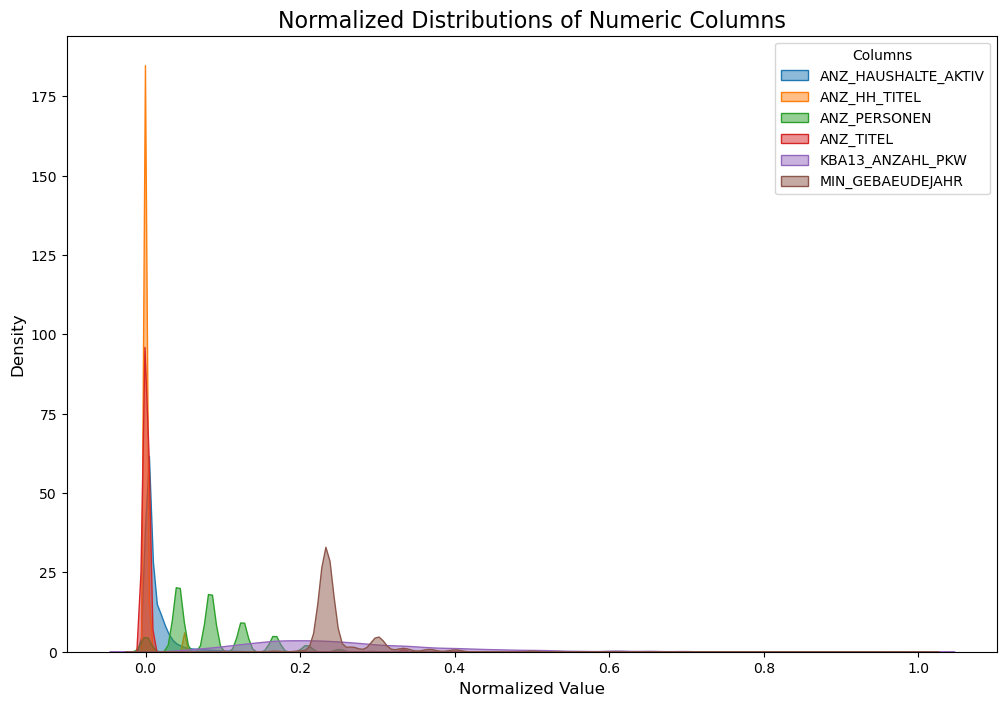

In [33]:
# Normalize the data (Min-Max Scaling)
normalized_data = (numeric_data - numeric_data.min()) / (numeric_data.max() - numeric_data.min())

# Plot the distributions
plt.figure(figsize=(12, 8))
for column in normalized_data.columns:
    # Plot the histogram of each column
    sns.kdeplot(normalized_data[column], label=column, fill=True, alpha=0.5)

plt.title('Normalized Distributions of Numeric Columns', fontsize=16)
plt.xlabel('Normalized Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Columns')
plt.show()

It seems obvious that many of the distributions are scewed, but lets do a numerical calcualtion

In [34]:
# Calculate skewness for each column
skewness_values = all_data[numeric_columns].skew()
print("Skewness of each column:")
print(skewness_values)

# Identify columns with high skewness (e.g., skewness > 1 or < -1)
high_skew_columns = skewness_values[abs(skewness_values) > 1].index.tolist()
print("Columns with high skewness:", high_skew_columns)

Skewness of each column:
ANZ_HAUSHALTE_AKTIV     8.572865
ANZ_HH_TITEL           21.508394
ANZ_PERSONEN            1.140757
ANZ_TITEL              11.743562
KBA13_ANZAHL_PKW        1.297599
MIN_GEBAEUDEJAHR        4.154490
dtype: float32
Columns with high skewness: ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']


In [35]:
# Log transform highly skewed columns and update azdias
for col in high_skew_columns:
    all_data[col] = np.log1p(all_data[col])


In [36]:
transformed_skewness = all_data[numeric_columns].skew()
print("\nSkewness After Log Transformation:")
print(transformed_skewness)


Skewness After Log Transformation:
ANZ_HAUSHALTE_AKTIV     1.124921
ANZ_HH_TITEL            6.849349
ANZ_PERSONEN           -0.257064
ANZ_TITEL              10.657099
KBA13_ANZAHL_PKW       -0.588755
MIN_GEBAEUDEJAHR        4.141036
dtype: float32


In [37]:
all_data['ANZ_TITEL'].value_counts()

ANZ_TITEL
0.000000    71258
0.693147      622
1.098612       55
1.386294        2
Name: count, dtype: int64

In [38]:
first_freq = all_data['ANZ_TITEL'].value_counts().iloc[0]
total_items= all_data['ANZ_TITEL'].notna().sum()
print(first_freq/total_items)

0.990561185481741


Considering 99% of the data is just one value we will just drop this column

this helped with some of the skewing, but ANZ_TITEL is still highly scewed. lets take a closer look at it

In [39]:
all_data = all_data.drop(columns='ANZ_TITEL')

In [40]:
numeric_columns.remove("ANZ_TITEL")

# Encode high dimentional features

Generally, when the number of unique categories is high, one-hot encoding becomes impractical as it produces a large number of columns. For these high-cardinality categorical variables, frequency encoding can help reduce the feature space.

In [44]:
# Count the total number of unique categories across all categorical columns
total_unique_categories = [(col, all_data[col].nunique()) for col in cat_columns]
# Sort the list by the nunique count in descending order
sorted_unique_categories = sorted(total_unique_categories, key=lambda x: x[1], reverse=True)

In [45]:
cat_columns = all_data.select_dtypes(['category']).columns
# Count the total number of unique categories across all categorical columns
total_unique_categories = [(col, all_data[col].nunique()) for col in cat_columns]
# Sort the list by the nunique count in descending order
sorted_unique_categories = sorted(total_unique_categories, key=lambda x: x[1], reverse=True)

for row in sorted_unique_categories:
    name,val = row
    if val > 50:
        print(row)

('EXTSEL992', 56)


Lets go ahead and frequency encode the top 4 features

In [46]:
for col, unique_count in sorted_unique_categories:
    if unique_count > 50:  # Arbitrary threshold
        print(col)
        freq = all_data[col].value_counts()
        all_data[col + '_freq'] = all_data[col].map(freq)
        all_data = all_data.drop(columns=[col])

EXTSEL992


In [47]:
cat_columns = all_data.select_dtypes(['category']).columns
# Count the total number of unique categories across all categorical columns
total_unique_categories = [(col, all_data[col].nunique()) for col in cat_columns]
# Sort the list by the nunique count in descending order
sorted_unique_categories = sorted(total_unique_categories, key=lambda x: x[1], reverse=True)
for row in sorted_unique_categories:
    name,val = row
    if val > 50:
        print(row)

# Standardize features and reduce memory footprint

In [48]:
# Assuming 'all_data' is your DataFrame
# numeric_cols = all_data.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns.tolist()
numeric_cols = all_data.select_dtypes(include=['float64',  'int64', ]).columns.tolist()
print("Numeric Columns:", numeric_cols)

Numeric Columns: ['EXTSEL992_freq']


In [49]:
# Separate numerical and categorical columns
num64_cols = all_data.select_dtypes(include=['int64', 'float64']).columns
num64_cols

Index(['EXTSEL992_freq'], dtype='object')

In [50]:
all_data[num64_cols] = all_data[num64_cols].astype('float32')

In [51]:
numeric_cols = all_data.select_dtypes(include=['float32', 'int32']).columns.tolist()

In [52]:
numeric_cols

['ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR',
 'EXTSEL992_freq']

In [53]:
all_data[numeric_cols].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,EXTSEL992_freq
count,70391.000000,69403.000000,71937.000000,69992.000000,70391.000000,54038.000000
mean,1.456662,0.027769,1.006662,6.287799,7.597831,4340.328125
std,0.925239,0.155860,0.452679,0.556104,0.001235,4517.605957
min,0.000000,0.000000,0.000000,0.000000,7.593878,2.000000
25%,0.693147,0.000000,0.693147,5.966147,7.597396,1062.000000
50%,1.098612,0.000000,1.098612,6.309918,7.597396,2471.000000
75%,2.079442,0.000000,1.386294,6.650279,7.597396,5027.000000
max,6.084499,3.044523,3.218876,7.741099,7.608871,12328.000000


In [54]:
data_scaler = StandardScaler()
all_data[numeric_cols] = data_scaler.fit_transform(all_data[numeric_cols])

In [55]:
all_data[numeric_cols].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,EXTSEL992_freq
count,7.039100e+04,6.940300e+04,7.193700e+04,6.999200e+04,7.039100e+04,5.403800e+04
mean,1.501145e-08,-6.843073e-09,-1.537821e-09,1.346197e-08,1.268115e-08,1.595399e-08
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000009e+00
min,-1.574374e+00,-1.781704e-01,-2.223803e+00,-1.130696e+01,-3.200693e+00,-9.603246e-01
25%,-8.252140e-01,-1.781704e-01,-6.925810e-01,-5.784070e-01,-3.519593e-01,-7.256849e-01
50%,-3.869837e-01,-1.781704e-01,2.031264e-01,3.977590e-02,-3.519593e-01,-4.137912e-01
75%,6.731054e-01,-1.781704e-01,8.386408e-01,6.518253e-01,-3.519593e-01,1.520005e-01
max,5.001808e+00,1.935573e+01,4.886971e+00,2.613379e+00,8.937793e+00,1.768137e+00


# One hot encode

In [56]:
cat_columns = all_data.select_dtypes(['category']).columns

In [57]:
cat_columns

Index(['AGER_TYP', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTERSKATEGORIE_FEIN',
       'ARBEIT', 'BALLRAUM', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015',
       'CAMEO_INTL_2015', 'CJT_GESAMTTYP',
       ...
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'RESPONSE', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB', 'type', 'GEBURTSJAHR_BINNED', 'Month',
       'Year_5yr_Bin'],
      dtype='object', length=347)

Lets make sure to remove response and type so to not modify those columns.

In [58]:
cat_columns = list(set(cat_columns) - {'RESPONSE', 'type'})

In [59]:
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
all_data[cat_columns] = cat_imputer.fit_transform(all_data[cat_columns])

In [60]:
encoded_df = pd.get_dummies(all_data[cat_columns], sparse=True)

In [61]:
encoded_df

,KBA13_CCM_1800_0,KBA13_CCM_1800_1,KBA13_CCM_1800_2,KBA13_CCM_1800_3,KBA13_CCM_1800_4,KBA13_CCM_1800_5,KBA13_VORB_3_0,KBA13_VORB_3_1,KBA13_VORB_3_2,KBA13_VORB_3_3,...,KBA13_BJ_1999_2,KBA13_BJ_1999_3,KBA13_BJ_1999_4,KBA13_BJ_1999_5,KBA13_KW_120_0,KBA13_KW_120_1,KBA13_KW_120_2,KBA13_KW_120_3,KBA13_KW_120_4,KBA13_KW_120_5
0,False,False,False,True,False,False,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False
1,False,False,False,False,True,False,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
2,True,False,False,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,True,False,False
3,True,False,False,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85790,False,False,False,True,False,False,False,False,False,True,...,False,True,False,False,False,False,False,True,False,False
85791,True,False,False,False,False,False,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False
85792,False,False,False,False,True,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,True
85793,True,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,True,False,False


In [62]:
# Recude encoded featurespace with variance tollerance thresholding

In [63]:
encoded_df = pd.get_dummies(all_data[cat_columns], sparse=True)
# 1. Remove low variance features (especially important for one-hot encoded columns)
selector = VarianceThreshold(threshold=0.01)  # 1% seems to be a reasonable threshold

In [64]:
selector.fit(encoded_df)


VarianceThreshold(threshold=0.01)

In [65]:
# Get selected feature names
selected_features = encoded_df.columns[selector.get_support()].tolist()
print(f"Features reduced from {encoded_df.shape[1]} to {len(selected_features)}")

Features reduced from 2222 to 1846


In [66]:
mask = selector.get_support()  # This is an array of booleans

In [68]:
encoded_df = encoded_df.loc[:, mask]

In [69]:
# make sure to include the target column and our devider columns
non_cat_df = all_data.drop(columns=cat_columns)

In [70]:
all_data = non_cat_df.join(encoded_df)

In [71]:
train_mask = all_data['type'] == 'train'
test_mask = all_data['type'] == 'test'


In [72]:
all_data = all_data.drop(columns='type')

In [73]:
df_test = all_data[test_mask]
df_train = all_data[train_mask]

In [74]:
X_train = df_train.drop(columns='RESPONSE')
y_train = df_train['RESPONSE'].astype(int)


In [76]:
# Check class distribution
def check_class_distribution(y):
    counter = Counter(y)
    print(f"Class distribution: {counter}")

print("Original class distribution:")
check_class_distribution(y_train)

Original class distribution:
Class distribution: Counter({0: 42430, 1: 532})


In [77]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [82]:


# Define a mapping from identifiers to class weight tuples
CLASS_WEIGHT_MAPPING = {
    'cw_0.5_40': (0.5, 40),
    'cw_0.7_30': (0.7, 30),
    'cw_1_20': (1, 20)
}

def objective(trial):
    # Define the hyperparameter space
    param = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'iterations': trial.suggest_int('iterations', 500, 1500),
        # Use string identifiers instead of tuples
        'class_weights': trial.suggest_categorical('class_weights', list(CLASS_WEIGHT_MAPPING.keys()))
    }
    
    # Retrieve the actual class weights from the mapping
    class_weights_dict = {0: CLASS_WEIGHT_MAPPING[param['class_weights']][0],
                          1: CLASS_WEIGHT_MAPPING[param['class_weights']][1]}
    
    # Initialize the model with the hyperparameters
    model = CatBoostClassifier(
        loss_function='Logloss', 
        eval_metric='PRAUC', 
        random_seed=42,
        verbose=0,  # Suppress output
        depth=param['depth'],
        learning_rate=param['learning_rate'],
        l2_leaf_reg=param['l2_leaf_reg'],
        iterations=param['iterations'],
        class_weights=class_weights_dict
    )
    
    # Split data into train and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    # Train the model
    model.fit(X_train_split, y_train_split, eval_set=(X_val_split, y_val_split), early_stopping_rounds=50)
    
    # Predict probabilities for the validation set
    y_pred = model.predict_proba(X_val_split)[:, 1]
    
    # Compute AUC score
    auc = roc_auc_score(y_val_split, y_pred)
    return auc

# Create and optimize the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)
print("Best AUC Score:", study.best_value)


[I 2024-12-28 12:40:42,512] A new study created in memory with name: no-name-3e5ad6a8-3fa4-4398-805d-7963bef16266
[I 2024-12-28 12:40:56,342] Trial 0 finished with value: 0.7891953509362821 and parameters: {'depth': 5, 'learning_rate': 0.02793059801314807, 'l2_leaf_reg': 5.350429629767392, 'iterations': 1002, 'class_weights': 'cw_1_20'}. Best is trial 0 with value: 0.7891953509362821.
[I 2024-12-28 12:41:08,657] Trial 1 finished with value: 0.7501884124665692 and parameters: {'depth': 9, 'learning_rate': 0.1539292826758879, 'l2_leaf_reg': 6.751554675032915, 'iterations': 1024, 'class_weights': 'cw_0.5_40'}. Best is trial 0 with value: 0.7891953509362821.
[I 2024-12-28 12:41:23,114] Trial 2 finished with value: 0.7716174126466451 and parameters: {'depth': 9, 'learning_rate': 0.03310142438078552, 'l2_leaf_reg': 8.384980291998911, 'iterations': 1265, 'class_weights': 'cw_0.5_40'}. Best is trial 0 with value: 0.7891953509362821.
[I 2024-12-28 12:41:34,979] Trial 3 finished with value: 0.79

Best Hyperparameters: {'depth': 8, 'learning_rate': 0.050216580661380406, 'l2_leaf_reg': 8.998889539274558, 'iterations': 516, 'class_weights': 'cw_0.5_40'}
Best AUC Score: 0.7926645857926996


In [84]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [88]:
best_params = study.best_params
best_params['class_weights'] = {0: 0.5, 1: 40}
best_params

{'depth': 8,
 'learning_rate': 0.050216580661380406,
 'l2_leaf_reg': 8.998889539274558,
 'iterations': 516,
 'class_weights': {0: 0.5, 1: 40}}

In [100]:
# Train and fit the model using the best hyperparameters
best_model = CatBoostClassifier(
    loss_function='Logloss', 
    eval_metric='PRAUC', 
    random_seed=42,
    verbose=100,  # Set to 100 to show training progress
    **best_params
)
best_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)
y_val_pred = best_model.predict_proba(X_val)[:, 1]
best_auc = roc_auc_score(y_val, y_val_pred)

print(f"Best Model AUC on Validation Set: {best_auc}")

0:	learn: 0.7549541	test: 0.6979534	best: 0.6979534 (0)	total: 37.4ms	remaining: 19.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7418816349
bestIteration = 30

Shrink model to first 31 iterations.
Best Model AUC on Validation Set: 0.7926645857926996


In [101]:
X_features = X_train.columns.tolist()


In [102]:
# 4. Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

In [103]:
feature_importance.head(20)

,feature,importance
1182,D19_SOZIALES_1,27.787978
602,D19_KONSUMTYP_MAX_2,3.193066
16,EINGEZOGENAM_HH_JAHR,1.422330
530,KBA13_CCM_2500_3,1.030702
991,D19_SONSTIGE_6,0.931474
1307,D19_GESAMT_ANZ_24_2,0.918764
1818,FINANZ_MINIMALIST_3,0.862446
421,SEMIO_DOM_6,0.837435
1540,SEMIO_TRADV_3,0.830092
12,D19_LOTTO,0.813876


In [107]:
# 5. Calculate validation metrics
metrics = {
    'auc_roc': roc_auc_score(y_val, y_pred_proba),
    'avg_precision': average_precision_score(y_val, y_pred_proba)
}

In [108]:
metrics

{'auc_roc': 0.7926645857926996, 'avg_precision': 0.04075032061667317}

In [109]:

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Find optimal threshold based on F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold_idx = np.argmax(f1_scores)
metrics['optimal_threshold'] = thresholds[optimal_threshold_idx]

/tmp/ipykernel_4347/2596134667.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [110]:
metrics

{'auc_roc': 0.7926645857926996,
 'avg_precision': 0.04075032061667317,
 'optimal_threshold': 0.7292753638343997}

In [112]:
# Evaluate the model on the test set
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.77      0.87      8487
           1       0.04      0.69      0.07       106

    accuracy                           0.77      8593
   macro avg       0.52      0.73      0.47      8593
weighted avg       0.98      0.77      0.86      8593



So clearly our model is suffering from a strong class imballance problem.  Next steps would to use a SMOTE or perhaps another method to help handle the class imballance, and finally try other models